In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from model import UNet

from utils import showExamples, showImages, showImage
from functional import linear_beta_schedule, forward_diffusion_sample
from Deep_Learning.Diffusion.MNIST_ldm.model import UNet, AutoEncoder

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

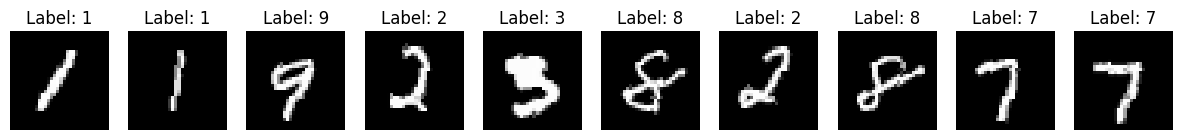

Max value: tensor(2.8215, device='cuda:0')
Min value: tensor(-0.4242, device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)
INPUT_SHAPE = (1, 32, 32)

# Used to pad the images from 28x28 to 32x32
# So the UNet can work with it.
# 32x32 is divisible by 2 multiple times, whereas 28x28 is not.
class PadTransform(object):
    def __call__(self, tensor):
        return F.pad(tensor, (2,2,2,2), mode='constant', value=0)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    PadTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

VAL_RATIO = 0.1
split_idx = int(len(dataset) * VAL_RATIO)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - split_idx, split_idx])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_dataset.transformed_images.max())
print('Min value:', train_dataset.transformed_images.min())

In [4]:
def train_ae(
    model,
    optimiser,
    criterion,
    train_set,
    val_set,
    epochs,
    batch_size,
    stats,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    if stats is None:
        stats = {
            'train_loss': [],
            'val_loss': [],
        }

    for epoch in range(epochs):

        loop = tqdm(train_loader, leave=False, desc=f'Epoch [{epoch + 1}/{epochs}]')
        if epoch > 0:
            loop.set_postfix({'train_loss': stats['train_loss'][-1], 'val_loss': stats['val_loss'][-1]})
        epoch_train_losses = torch.zeros(len(train_loader))
        for batch, (x, _) in enumerate(loop):
            optimiser.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optimiser.step()
            epoch_train_losses[batch] = loss.item()
        stats['train_loss'].append(epoch_train_losses.mean().item())

        with torch.no_grad():
            epoch_val_losses = torch.zeros(len(val_loader))
            for batch, (x, _) in enumerate(val_loader):
                x_hat = model(x)
                loss = criterion(x_hat, x)
                epoch_val_losses[batch] = loss.item()
            val_loss = epoch_val_losses.mean().item()            
            if len(stats['val_loss']) == 0 or val_loss < min(stats['val_loss']):
                torch.save(model.state_dict(), 'Deep_Learning/Diffusion/MNIST_ldm/best_ae_model.pth')
            stats['val_loss'].append(val_loss)
        

    return stats

Training model...


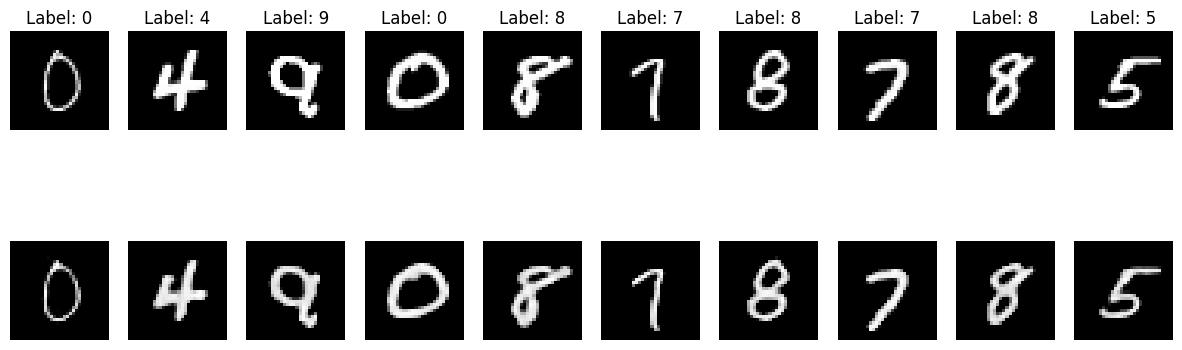

In [47]:
ae = AutoEncoder(INPUT_SHAPE, [1, 8, 16, 32]).to(device)
optimiser = torch.optim.AdamW(ae.parameters(), lr=1e-3)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
stats = None
num_epochs = 20
batch_size = 128
# Load model if exists, else train
try:
    ae.load_state_dict(torch.load('Deep_Learning/Diffusion/MNIST_ldm/best_ae_model.pth'))
    print('Loaded model')
except FileNotFoundError:
    print('Training model...')
    stats = train_ae(ae, optimiser, criterion, train_dataset, val_dataset, num_epochs, batch_size, stats)

# Show example images
fig, axes = plt.subplots(2, 10, figsize=(15,5))
for i, ax in enumerate(axes[0]):
    img, label = val_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

    img = ae(img.unsqueeze(0)).squeeze()
    ax = axes[1, i]
    ax.imshow(img.cpu().detach(), cmap='gray')
    ax.axis('off')

In [48]:
IMG_SIZE = 8
BATCH_SIZE = 128

# Values for closed form
T = 300
BETA_0 = 0.0001
BETA_T = 0.02
BETAS = linear_beta_schedule(T, BETA_0, BETA_T)

ALPHAS = 1.0 - BETAS
ALPHAS_CUMPROD = torch.cumprod(ALPHAS, dim=0)
ALPHAS_CUMPROD_PREV = F.pad(ALPHAS_CUMPROD[:-1], (1, 0), value=1.0)
SQRT_RECIP_ALPHAS = torch.sqrt(1.0 / ALPHAS)
SQRT_ALPHAS_CUMPROD = torch.sqrt(ALPHAS_CUMPROD)
SQRT_ONE_MINUS_ALPHAS_CUMPROD = torch.sqrt(1.0 - ALPHAS_CUMPROD)
POSTERIOR_VARIANCE = BETAS * (1.0 - ALPHAS_CUMPROD_PREV) / (1.0 - ALPHAS_CUMPROD)

In [49]:
def train(
        model,
        ae,
        train_set,
        optimiser,
        criterion,
        losses = [],
        num_epochs=10,
):
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    for epoch in range(num_epochs):
        train_set.apply_transform()

        epoch_loss = 0.0
        loop = tqdm(train_loader, total=len(train_loader), leave=False)

        for img, _ in loop:
            data = ae.encoder(img)

            # ts = torch.randint(0, T, (data.shape[0],1), device=device).long()
            ts = torch.randint(0, T, (data.shape[0],), device=device).long()
            noisy, noise = forward_diffusion_sample(data, ts.to('cpu'), SQRT_ALPHAS_CUMPROD, SQRT_ONE_MINUS_ALPHAS_CUMPROD, device)
            y_p = model(noisy, ts)

            loss = criterion(y_p, noise)

            epoch_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            if epoch > 0:
                loop.set_postfix(loss=losses[-1])

        epoch_loss = epoch_loss / len(train_loader)
        if epoch == 0 or epoch_loss < min(losses):
            torch.save(model.state_dict(), 'Deep_Learning/Diffusion/MNIST_ldm/best_ldm_model.pth')
        losses.append(epoch_loss)
    return losses

In [52]:
model = UNet(
    32,
    [8, 4, 2],
    BETAS,
    SQRT_ALPHAS_CUMPROD,
    SQRT_ONE_MINUS_ALPHAS_CUMPROD,
    SQRT_RECIP_ALPHAS,
    POSTERIOR_VARIANCE,
    T,
).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=0.00034)
# L1 loss is the mean absolute error
# criterion = torch.nn.L1Loss()
criterion = torch.nn.MSELoss()
losses = []

In [53]:
try:
    model.load_state_dict(torch.load('Deep_Learning/Diffusion/MNIST_ldm/best_ldm_model.pth'))
    print('Loaded model')
except FileNotFoundError:
    losses = train(model, ae, train_dataset, optimiser, criterion, losses, num_epochs=200)
    print('Trained model')

Trained model


Text(0.5, 0, 'Epoch')

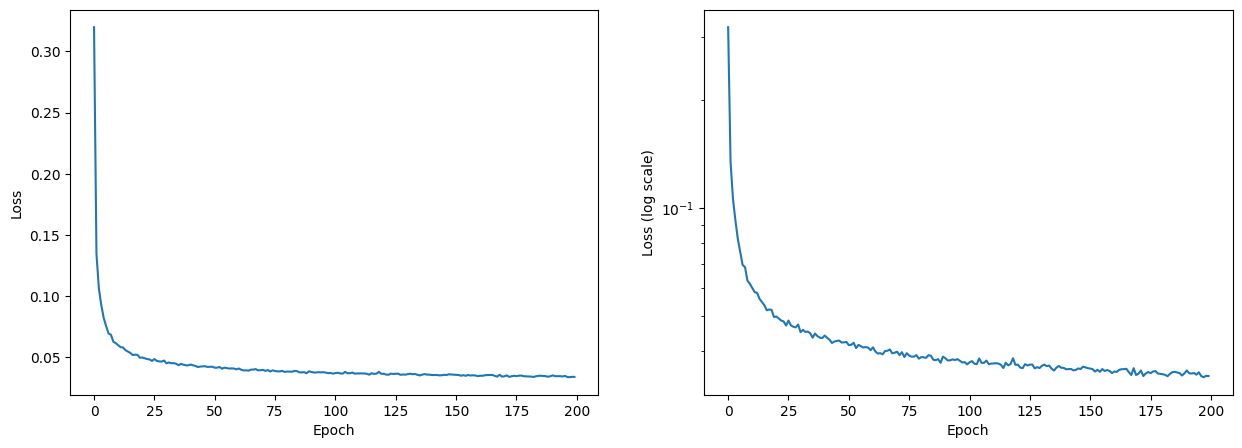

In [54]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(losses)
plt.yscale('log')
plt.ylabel('Loss (log scale)')
plt.xlabel('Epoch')

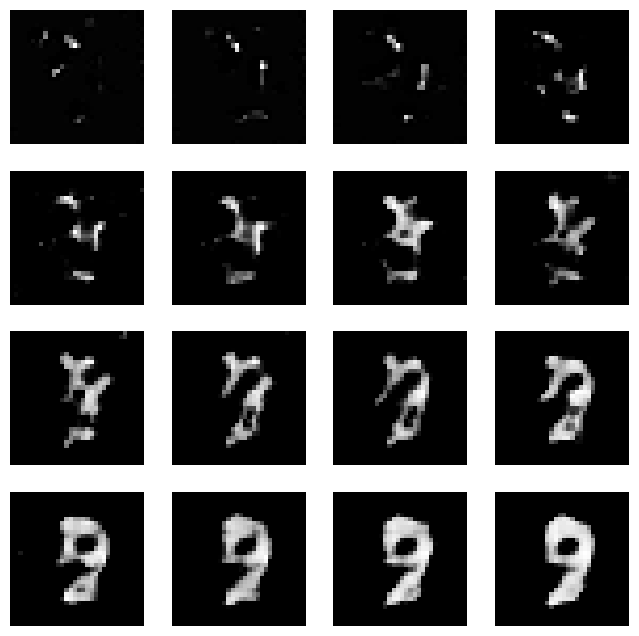

In [84]:
# # Takes 16 images and plots them in a 4x4 grid
# def showExamples(imgs):
#     assert len(imgs) == 16, "Number of images must be 16"
#     plt.figure(figsize=(8,8))
#     for i in range(16):
#         plt.subplot(4,4,i+1)
#         plt.imshow(imgs[i].squeeze().cpu(), cmap='gray')
#         plt.axis('off')
#     plt.show()
    
samples = model.sample_steps(15)[4:]
samples = [ae.decoder(sample).cpu().detach() for sample in samples]
showExamples(samples)

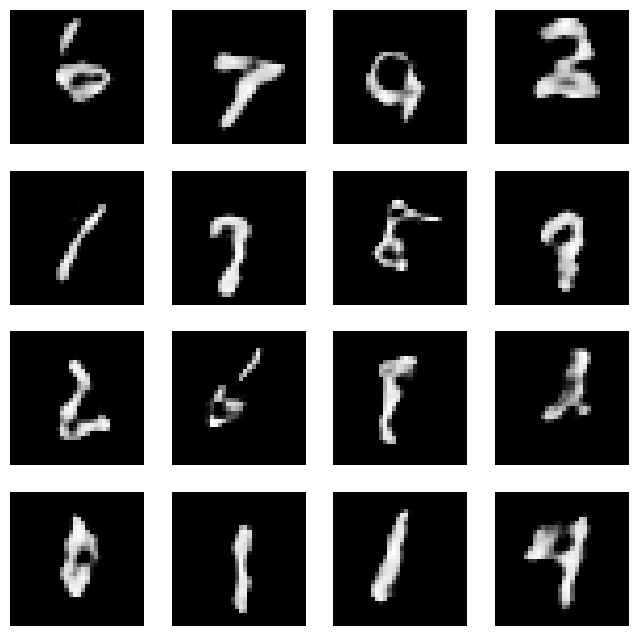

In [92]:
samples = ae.decoder(model.sample()).detach()
samples.shape
showExamples(samples)